# CV基础（下）

## TASK01. Harris 特征点检测器
### 特征点
1. 旋转不变性和光照不变性和视角不变性
2. e.g.突出的角点、边缘端点、极值点
3. 算法：Harris角点检测、FAST特征检测、SIFT特征检测及SURF特征检测

###  角点
1. 利用“滑动窗口”滑动时像素值的变化来判断是否为“角”（平滑/Edges/Corners）
2. 变化：由梯度描述（差分近似）；梯度算子卷积求梯度值

### Harris角点检测算法
1. 核心：局部窗口移动并判断灰度是否变化较大
2. 三步：计算x y像素变化量E(x,y)；计算窗口对应的角点响应函数R（？）；对R阈值处理
3. 问题：怎样合并窗口中多个像素的梯度特征？(不合并？）R的自变量？（不同方向，不同像素？）

#### 1.数学模型

$$
E(x,y) = \sum w(x,y) *[I(x,y)+uI_x +vI_y-I(x,y)]^2 \\
=\sum w(x,y)*(uI_x + vI_y)^2\\
=\sum w(x,y)*(u^2I_x^2+v^2I_y^2 +2uvI_x I_y)\\
=[u,v]M [u,v]^T 
$$
M是实对称矩阵，对角化得到M=Q^-1 P Q
Q是正交单位矩阵，可以看成是旋转因子，不影响两个正交反向的变化分量。

#### 2.角点响应函数
用于判断灰度值变化的大小，由E生成,E 取决于M，因此R(M)
$$
R=det(M)-k(trace(M))^2\\
=\lambda _1 \lambda _2 -k(\lambda _1 +\lambda_2)^2
$$
$ \lambda $是矩阵M的特征值，代表了两个正交方向上的梯度  
k是经验常数，(0.04,0.06)  
R 的值取决于M的特征值，对于角点|R|很大，平坦的区域|R|很小，边缘的R为负值。 

#### 3.角点判定
平面:：该窗口在平坦区域上滑动，窗口内的灰度值基本不会发生变化，所以 |R| 值非常小，在水平和竖直方向的变化量均较小，即 Ix和 Iy都较小，那么 λ1 和 λ2 都较小；

边缘：|R|值为负数，仅在水平或竖直方向有较大的变化量，即 Ix和 Iy只有一个较大，也就是 λ1>>λ2 或 λ2>>λ1；

角点：R 值很大，在水平、竖直两个方向上变化均较大的点，即 Ix和 Iy 都较大，也就是 λ1 和 λ2 都很大。

#### 4.OpenCV实现
函数原型： 
`cv2.cornerHarris(src,blockSize,ksize,k[,dst[,borderType]])`
blocksize即窗口尺寸
ksize指滤波核sobel算子的尺寸

In [3]:
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np

(384, 576, 3)
width: 576  height: 384  channels: 3


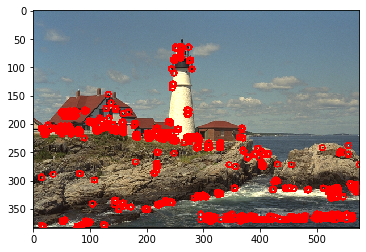

In [14]:
# detector parameters
block_size = 3 #(3*3 window)
sobel_size = 3
k = 0.035

image = cv.imread('scenery.png')

print(image.shape)
height = image.shape[0]
width = image.shape[1]
channels = image.shape[2]
print("width: %s  height: %s  channels: %s"%(width, height, channels))
   
gray_img = cv.cvtColor(image, cv.COLOR_BGR2GRAY)


# modify the data type setting to 32-bit floating point 
gray_img = np.float32(gray_img)

#调用api 角点检测
# detect the corners with appropriate values as input parameters
corners_img = cv.cornerHarris(gray_img, block_size, sobel_size, k)

# 结果可视化
# result is dilated for marking the corners, not necessary
kernel = cv.getStructuringElement(cv.MORPH_RECT,(3, 3))
dst = cv.dilate(corners_img, kernel)

# Threshold for an optimal value, marking the corners in Green
#image[corners_img>0.01*corners_img.max()] = [0,0,255]

for r in range(height):
        for c in range(width):
            pix=dst[r,c]
            if pix>0.05*dst.max():
               cv.circle(image,(c,r),5,(0,0,255),0)

image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

#### Harris角点检测的性质：

1. 阈值决定角点的数量

2. 对亮度和对比度的变化不敏感（光照不变性） 
在进行Harris角点检测时，使用了微分算子对图像进行微分运算，而微分运算对图像密度的拉升或收缩和对亮度的抬高或下降不敏感。换言之，<B>对亮度和对比度的仿射变换并不改变Harris响应的极值点出现的位置，但是，由于阈值的选择不同，可能会影响角点检测的数量。

3. 具有旋转不变性，但不具有尺度不变性

#### 其他
1. 参数k对角点检测的影响？
增大k的值，将减小角点响应值R，降低角点检测的灵性，减少被检测角点的数量；减小k值，将增大角点响应值R，增加角点检测的灵敏性，增加被检测角点的数量。
数学推导参考 [☆Ronny丶](https://www.cnblogs.com/ronny/p/4009425.html)


2. 多尺度Harris角点？  
结合高斯尺度空间表示（[待看](https://www.cnblogs.com/ronny/p/3886013.html)）  
大概思路：通过滤波+抽样算法构建出“高斯金字塔”，再用高斯金字塔本层图像与高一级图像插值放大后图像的差构建出“拉普拉斯金字塔”（相当于带通滤波），safhdsahdkhciuewt（？）然后扫描金字塔的每一层图像，对最合适的尺度（以特征提取效果判断？）进行后续处理（如人脸识别）。